<a href="https://colab.research.google.com/github/Nakib-Nasrullah/Research-Skill/blob/main/final_predef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# Reinstall pandas to the version compatible with Colab environment (2.2.2).
# This addresses the dependency conflict highlighted by the 'pip' error messages
# and ensures compatibility with other pre-installed Colab packages.
import wfdb
import numpy as np
import pandas as pd
import os

In [3]:
# Download dataset
DATA_DIR = "mitdb"
if not os.path.exists(DATA_DIR):
    wfdb.dl_database('mitdb', dl_dir=DATA_DIR)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [4]:
#Parameters
WINDOW = 187
HALF = WINDOW // 2

label_map = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,
    'A': 1, 'a': 1, 'J': 1, 'S': 1,
    'V': 2, 'E': 2,
    'F': 3
}

beats = []

records = sorted([f.split('.')[0] for f in os.listdir(DATA_DIR) if f.endswith('.dat')])

for record in records:
    try:
        signal, _ = wfdb.rdsamp(os.path.join(DATA_DIR, record))
        ann = wfdb.rdann(os.path.join(DATA_DIR, record), 'atr')
    except:
        continue

    ecg = signal[:, 0]
    for r, sym in zip(ann.sample, ann.symbol):
        if sym not in label_map:
            continue
        if r - HALF < 0 or r + HALF >= len(ecg):
            continue
        beat = ecg[r-HALF:r+HALF+1]
        if len(beat) == WINDOW:
            beats.append([record] + beat.tolist() + [label_map[sym]])

columns = ["record_id"] + [f"f{i}" for i in range(WINDOW)] + ["label"]
df = pd.DataFrame(beats, columns=columns)
df.to_csv("mitbih_patient_level.csv", index=False)

print(" mitbih_patient_level.csv created")

 mitbih_patient_level.csv created


In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("mitbih_patient_level.csv")

patients = df['record_id'].unique()

train_patients, test_patients = train_test_split(
    patients, test_size=0.30, random_state=42
)

train_df = df[df['record_id'].isin(train_patients)]
test_df  = df[df['record_id'].isin(test_patients)]

assert set(train_df['record_id']).isdisjoint(set(test_df['record_id']))

train_df.to_csv("mitbih_train_patient.csv", index=False)
test_df.to_csv("mitbih_test_patient.csv", index=False)

print(" Patient-independent split saved")

 Patient-independent split saved


In [6]:
import numpy as np
import pandas as pd

train_df = pd.read_csv("mitbih_train_patient.csv")
test_df  = pd.read_csv("mitbih_test_patient.csv")

print(train_df.shape, test_df.shape)

(69432, 189) (31994, 189)


In [7]:
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['label'].values.astype(int)

X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['label'].values.astype(int)

# Per-beat normalization
X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / (X_train.std(axis=1, keepdims=True) + 1e-8)
X_test  = (X_test  - X_test.mean(axis=1, keepdims=True))  / (X_test.std(axis=1, keepdims=True)  + 1e-8)

X_train = X_train.reshape(-1, 187, 1)
X_test  = X_test.reshape(-1, 187, 1)

print("CNN input:", X_train.shape)

CNN input: (69432, 187, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(187, 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 183, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,420 (1.39 MB)

 Trainable params: 363,972 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(0.2827404222048475), 1: np.float64(7.430650684931507), 2: np.float64(3.286255206361227), 3: np.float64(41.132701421800945)}


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

history = model.fit(
    X_train,
    y_train,
    epochs=12,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 76s 73ms/step - accuracy: 0.9566 - loss: 0.1784 - val_accuracy: 0.9762 - val_loss: 0.1301
Epoch 2/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 64s 66ms/step - accuracy: 0.9835 - loss: 0.0650 - val_accuracy: 0.9836 - val_loss: 0.0954
Epoch 3/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 63s 65ms/step - accuracy: 0.9871 - loss: 0.0490 - val_accuracy: 0.9700 - val_loss: 0.1268
Epoch 4/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.9888 - loss: 0.0419 - val_accuracy: 0.9837 - val_loss: 0.1061
Epoch 5/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - accuracy: 0.9899 - loss: 0.0349 - val_accuracy: 0.9716 - val_loss: 0.1256
Epoch 6/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 63s 65ms/step - accuracy: 0.9894 - loss: 0.0364 - val_accuracy: 0.9806 - val_loss: 0.1277
Epoch 7/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.9922 - loss: 0.0281 - val_accuracy: 0.9497 - val_loss: 0.2092
Epoch 8/12
977/977 ━━━━━━━━━━━━━━━━━━━━ 67s 69ms/step - accuracy: 0.9912 - loss: 0.0279 - 

In [11]:
model.save("mitbih_cnn_patient_independent.h5")
print(" Model saved")

 Model saved


In [12]:
from tensorflow.keras.models import load_model

model = load_model("mitbih_cnn_patient_independent.h5")
#cell 10
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(" Patient-independent Test Accuracy:", test_acc)

 Patient-independent Test Accuracy: 0.9028567671775818


In [13]:
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


In [14]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=["Normal", "Supraventricular", "Ventricular", "Fusion"]
))

                  precision    recall  f1-score   support

          Normal       0.97      0.92      0.95     29216
Supraventricular       0.24      0.22      0.23       445
     Ventricular       0.49      0.94      0.64      1953
          Fusion       0.01      0.01      0.01       380

        accuracy                           0.90     31994
       macro avg       0.43      0.52      0.46     31994
    weighted avg       0.92      0.90      0.91     31994



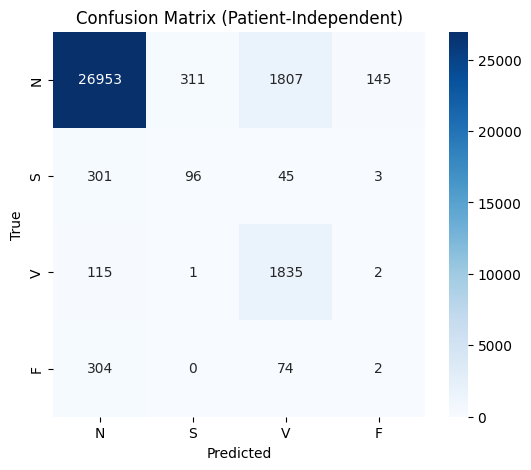

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["N","S","V","F"],
            yticklabels=["N","S","V","F"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Patient-Independent)")
plt.show()

In [16]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

Macro F1: 0.45561334790171387
Weighted F1: 0.9077153307781176


In [26]:
# 1. Call model first to build layers
_ = model.predict(X_test[:1])

# 2. Pick one sample
idx = 10
x_sample = X_test[idx:idx+1]
true_label = y_test[idx]
pred_label = y_pred[idx]

# 3. Check correct last Conv1D layer name
model.summary()  # look at conv layer names
layer_name = "conv1d_2"  # update according to summary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 183, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,422 (1.39 MB)

 Trainable params: 363,972 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

NameError: name 'cam' is not defined

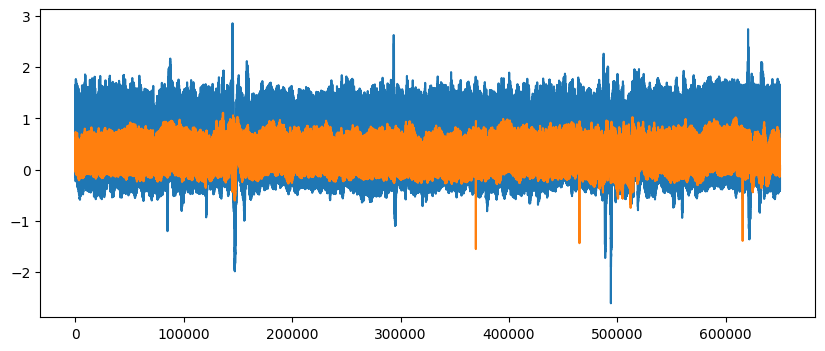

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(signal, label="ECG Signal")
plt.plot(cam * np.max(signal), label="Grad-CAM", color='red')
plt.legend()
plt.title(f"Grad-CAM (True={true_label}, Pred={pred_label})")
plt.show()